In [102]:
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import tensorflow as tf

from tqdm import tqdm_notebook
from scipy.spatial.distance import hamming, cosine, euclidean

%matplotlib inline
tf.executing_eagerly()


True

In [2]:
def image_load(path, image_size):
    """
    Load image

    :param path: String, path to image
    :image_size: tuple, size of output image
    """
    
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, image_size, cv2.INTER_CUBIC)
    return image

In [81]:
def data_preprocessing(data_path, labels_path, image_size, image_path_pickle):
    """
    Load image and labels

    :param data_path: String, path to train and test data
    :param labels_path: String, path to label
    :param image_size: tuple, single imaze size
    :param image_path_pickle: String, name of a pickle file where all image will be saved
    """
    with open(labels_path) as f:
        classes = f.read().split("\n")[: -1]

    images = []
    labels = []
    # path to pickle
    image_paths = []
    
    for image_name in os.listdir(data_path):
        try:

                # create full path to train data
                image_path = os.path.join(data_path, image_name)
                images.append(image_load(image_path, image_size))
                image_paths.append(image_path)
                for idx in range(len(classes)):
                    if classes[idx] in image_name:
                        labels.append(idx)
        except:
                pass
    
    with open(image_path_pickle + ".pickle", "wb") as f:
        pickle.dump(image_paths, f)

    assert len(images) == len(labels)
    return np.array(images, dtype="float32"), np.array(labels, dtype="float32")

In [82]:
images, labels = data_preprocessing("dataset/train", "dataset/labels.txt", (32, 32), "training_image_pickle")

In [83]:
images.shape, labels.shape

((50000, 32, 32, 3), (50000,))

In [84]:
def cosine_distance(training_set_vector, query_vector, top_n=50):
    """
    calculate cosine distance between query image and all trianing set image
    
    :param training_set_vector: numpy Matrix, vectors for all images in training set
    :param query_vector: numpy vector, query image(new image)
    :param top_n: interger, number of closest image to return
    """
    
    distances = []
    
    for i in range(len(training_set_vector)): # for train dataset 50k image
        distance.append(cosine(training_set_vector[i], query_vector[0]))
    
    return np.argsort(distance)[:top_n]
        

In [85]:
def hamming_distance(training_set_vector, query_vector, top_n=50):
    """
    calculate haming distance between query image and all training images
    
    :param training_set_vector: numpy Matrix, vectors for all images in training set
    :param query_vector: numpy vector, query image(new image)
    :param top_n: interger, number of closest image to return
    """
    
    distance = []
    
    for i in range(len(training_set_vector)):
        distance.append(hamming(training_set_vector[i], query_vector[0]))
    
    return np.argsort(distance)[:top_n]

In [86]:
def cal_accuracy(y_true, y_pred):
    """
    calculate accuracy of model on softmax outputs
    
    :param y_true: numpy array, true labels of each sample
    :param y_pred: numpy matrix, softmax probabilities
    """
    
    assert len(y_true) == len(y_pred)
    
    correct = 0
    
    for i in range(len(y_true)):
        if np.argmax(y_pred[i]) == y_true[i]:
                correct += 1
    
    return correct / len(y_true)

In [87]:
class Conv(tf.keras.layers.Layer):
    
    def __init__(self, number_of_filter, kernel_size, stride=(1, 1),
                padding="SAME", activation="tf.nn.relu",
                max_pool=True, batch_norm=True):
        
        """
        define convolutional block layer

        :param number_of_filter: interger, number of filter
        :param kernel_size: tuple, size of conv layer kernel
        :param padding: String, type of padding SAME or VALID
        :param activation: tf.object, activation functuin used on the layer
        :param max_pool: boolean, true conv layer use max pooling
        :param batch_norm: boolean, true conv layer use batch normalization
        """

        super(Conv, self).__init__()

        self.conv_layer = tf.keras.layers.Conv2D(filters=number_of_filter,
                                                                                    kernel_size=kernel_size,
                                                                                    strides=stride,
                                                                                    padding=padding,
                                                                                    activation=activation)

        self.max_pool = max_pool
        if max_pool:
            self.max_pool_layer = tf.keras.layers.MaxPooling2D(pool_size=(2, 2),
                                                                                                  strides=(2, 2),
                                                                                                  padding="SAME")

        self.batch_norm = batch_norm
        if batch_norm:
            self.batch_norm_layer = tf.keras.layers.BatchNormalization()

    def call(self, inputs, training):
        conv_features = x = self.conv_layer(inputs)
        if self.max_pool:
            x = self.max_pool_layer(x)
        if self.batch_norm:
            x = self.batch_norm_layer(x, training)
        
        return x, conv_features

In [88]:
class Dense(tf.keras.layers.Layer):
    def __init__(self, units, activation=tf.nn.relu, dropout=None, batch_norm=True):
        """
        define Dense layer
        
        :param units: interger, number of neurons
        :param activation: tf.object, activation functuin used on the layer
        :param dropout: dropout rate
        :param batch_norm: boolean, true conv layer use batch normalization
        """
        
        super(Dense, self).__init__()
        
        self.dense_layer = tf.keras.layers.Dense(units, activation=activation)
        
        self.dropout = dropout
        if dropout is not None:
            self.dropout_layer = tf.keras.layers.Dropout(dropout)
        
        self.batch_norm = batch_norm
        if batch_norm:
            self.batch_norm_layer = tf.keras.layers.BatchNormalization()
    
    def call(self, inputs, training):
        dense_feature = x = self.dense_layer(inputs)
        if self.dropout is not None:
            x = self.dropout_layer(x, training)
        if self.batch_norm:
            x = self.batch_norm_layer(x, training)
        return x, dense_feature

In [11]:
class BuildModel(tf.keras.Model):
    
    def __init__(self, dropout, image_size, number_of_calsses=10):
        """
        Build a model for image search
        
       :param dropout: dropout rate
       :param image_size: tuple, (height, width)
       :param number_of_calsses: integer, number of classes
       """
        
        super(BuildModel, self).__init__()
        
        self.batch_normalize_layer = tf.keras.layers.BatchNormalization()
        
        self.conv_1 = Conv(number_of_filter=64,
                                        kernel_size=(3, 3),
                                        stride=(1, 1),
                                        padding="SAME",
                                        activation=tf.nn.relu,
                                        max_pool=True,
                                        batch_norm=True)
        
        self.conv_2 = Conv(number_of_filter=128,
                                        kernel_size=(3, 3),
                                        stride=(1, 1),
                                        padding="SAME",
                                        activation=tf.nn.relu,
                                        max_pool=True,
                                        batch_norm=True)
        
        self.conv_3 = Conv(number_of_filter=256,
                                        kernel_size=(5, 5),
                                        stride=(1, 1),
                                        padding="SAME",
                                        activation=tf.nn.relu,
                                        max_pool=True,
                                        batch_norm=True)
        
        self.conv_4 = Conv(number_of_filter=512,
                                        kernel_size=(5, 5),
                                        stride=(1, 1),
                                        padding="SAME",
                                        activation=tf.nn.relu,
                                        max_pool=True,
                                        batch_norm=True)

        self.flatten_layer = tf.keras.layers.Flatten()
        
        self.dense_1 = Dense(units=128,
                                            activation=tf.nn.relu,
                                            dropout=dropout,
                                            batch_norm=True)

        self.dense_2 = Dense(units=256,
                                            activation=tf.nn.relu,
                                            dropout=dropout,
                                            batch_norm=True)

        self.dense_3 = Dense(units=512,
                                            activation=tf.nn.relu,
                                            dropout=dropout,
                                            batch_norm=True)

        self.dense_4 = Dense(units=1024,
                                            activation=tf.nn.relu,
                                            dropout=dropout,
                                            batch_norm=True)
        
        self.final_dense = tf.keras.layers.Dense(units=number_of_calsses,
                                                                        activation=None)
        
        self.final_siftmax = tf.keras.layers.Softmax()
    
    def call(self, inputs, training):
        x = self.batch_normalize_layer(inputs, training)
        x, conv1 = self.conv_1(x, training)
        x, conv2 = self.conv_2(x, training)
        x, conv3 = self.conv_3(x, training)
        x, conv4 = self.conv_4(x, training)
        
        x = self.flatten_layer(x)
        
        x, dense1 = self.dense_1(x, training)
        x, dense2 = self.dense_2(x, training)
        x, dense3 = self.dense_3(x, training)
        x, dense4 = self.dense_4(x, training)
        
        x = self.final_dense(x)
        output = self.final_siftmax(x)
        
        return output, dense2, dense4

In [47]:
model = BuildModel(0.5, (32, 32), 10)

In [55]:
def train(model, epochs, batch_size, learning_rate,
                dataset, dir_save, saver_delta=0.15, patience=2):
    """
    Train model
    
    :param model: CNN model
    :param epochs: interger, number of epochs
    :params batch_size: interger, number of batch
    :param laerning_rate: float, number of learning rate
    :param dataset: tuple, train and test dataset
    :param dir_save: String, path to a folder where model checkpoint will be saved
    :param saver_delta: float, used to prevent overfitted model to be saved
    :param patience: float, used for early stopping
    """
    
    #Call dummy predict to instantiate
    model.predict(x=np.random.randn(1, 32, 32, 3).astype('float32'))
    
    X_train, y_train, X_val, y_val = dataset
    
    best_accuracy = 0

    optimizer = tf.keras.optimizers.Adam(lr=learning_rate)
    loss_func =  tf.keras.losses.SparseCategoricalCrossentropy()
    
    epoch_val_accuracy = []
    counter = 0
    
    for epoch in range(epochs):
        
        train_acc = []
        train_loss = []
        
        for i in tqdm_notebook(range(len(X_train) // batch_size)):
            
            start_id = i * batch_size
            end_id = start_id + batch_size
            
            x_batch = X_train[start_id: end_id]
            y_batch = y_train[start_id: end_id]
            
            with tf.GradientTape() as tape:
                probs, _, _ = model(x_batch, training=True)
                loss_value = loss_func(y_batch, probs)
            
            grads = tape.gradient(loss_value, model.trainable_weights)
            optimizer.apply_gradients(zip(grads, model.trainable_weights))
            
            train_acc.append(cal_accuracy(y_batch, probs))
            train_loss.append(loss_value)
                    
        test_acc = []
        
        for i in tqdm_notebook(range(len(X_val) // batch_size)):
            start_id = i * batch_size
            end_id = start_id + batch_size

            x_val_batch = X_val[start_id: end_id]
            y_val_batch = y_val[start_id: end_id]
            
            val_prob, _, _ = model(x_val_batch, training=False)
            
            test_acc.append(cal_accuracy(y_val_batch, val_prob))
            
        print("Epochs %s" % epoch)
        print("train acc {}".format(np.mean(train_acc)))
        
        mean_val_acc = np.mean(test_acc)
        print("val acc {}".format(mean_val_acc))
        
        epoch_val_accuracy.append(mean_val_acc)
        
        if mean_val_acc <= best_accuracy:
            counter += 1
            if counter >= patience:
                print("Early stopping")
                return
        
        else:
            counter = 0
            best_accuracy = mean_val_acc
        
        if np.mean(train_acc) > np.mean(test_acc): # prevent underfitting
            if np.abs(np.mean(train_acc) - np.mean(test_acc)) <= saver_delta: # prevent overfitting
                if np.mean(test_acc) >= best_accuracy:
                    best_accuracy = np.mean(test_acc)
                    model.save(os.path.join(dir_save, f"model_epoch_{epoch+1}"), save_format='tf')

**define hyperparameter**

In [56]:
epochs = 2
batch_size = 256
learning_rate = 0.01
dropout_rate = 0.5
image_size = (32, 32)

In [89]:
# load train set
X_train, y_train = data_preprocessing("dataset/train", "dataset/labels.txt", image_size=image_size, image_path_pickle="train_image_pickls")

In [90]:
X_train.shape, y_train.shape

((50000, 32, 32, 3), (50000,))

In [91]:
# load validation set
X_val, y_val = data_preprocessing("dataset/test", "dataset/labels.txt", image_size=image_size, image_path_pickle="test_image_pickls")

In [20]:
X_val.shape, y_val.shape

((10000, 32, 32, 3), (10000,))

In [57]:
# define model
model = BuildModel(dropout_rate, image_size)

In [43]:
dataset = (X_train, y_train, X_val, y_val)

In [58]:
train(model=model, epochs=epochs, batch_size=batch_size, learning_rate=learning_rate, dataset=dataset, dir_save="saver")


Epochs 0
train acc 0.26390224358974357
val acc 0.29407051282051283



Epochs 1
train acc 0.3773036858974359
val acc 0.374599358974359


W0124 18:34:55.749768 140735587754880 deprecation.py:506] From /Users/miyamotoatsushi/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/ops/resource_variable_ops.py:1786: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


**create train set vector**


In [92]:
def create_train_vector(model, X_train, y_train, batch_size, image_size, distance="hamming"):
    """
    Create training set vector and save them in a pickle file
    
    :param model: model CNN model
    :param X_train: numpy array, train set
    :param y_train: numpy array, test set
    :param batch_size: integer, number of sample
    :param image size: tuple, single image (height, width)
    :param distance: String, type of distance to be used
    """
    
    dense_2_feature = []
    dense_4_feature = []
    
    # calculate color features vectors for each image in the train data
    color_feature = []
    for img in X_train:
        channels = cv2.split(img)
        feature = []
        for chan in channels:
            hist = cv2.calcHist([chan], [0], None, [256], [0, 256])
            feature.append(hist)
        
        color_feature.append(np.vstack(feature).squeeze())
    
    # iterate train set
    for i in tqdm_notebook(range(len(X_train) // batch_size)):
        start_id =  i * batch_size
        end_id = start_id + batch_size
        
        X_batch = X_train[start_id: end_id]
        _, dense_2, dense_4 = model(X_batch, training=False)
        
        dense_2_feature.append(dense_2)
        dense_4_feature.append(dense_4)
    
    dense_2_feature = np.vstack(dense_2_feature)
    dense_4_feature = np.vstack(dense_4_feature)
    
    # hamming distance - vector processing
    if distance == "hamming":
        dense_2_feature = np.where(dense_2_feature < 0.5, 0, 1)
        dense_4_feature = np.where(dense_4_feature < 0.5, 0, 1)
        
        train_vectors = np.hstack((dense_2_feature, dense_4_feature))
        with open("hamming_train.pickle", "wb") as f:
            pickle.dump(train_vectors, f)
    
    # cosine distance
    elif distance == "cosine":
        train_vectors = np.hstack((dense_2_feature, dense_4_feature))
        train_vectors = np.hstack((train_vectors, color_feature[: len(train_vectors)]))
        with open("cosine_train.pickle", "wb") as f:
            pickle.dump(train_vectors, f)

    # save training set color feature vector to sparete pickle file
    with open("color_featuer.pickle", "wb") as f:
        pickle.dump(color_feature[: len(train_vectors)], f)

In [61]:
#Load the best mode
model = tf.keras.models.load_model(os.path.join("saver", "model_epoch_2"))

In [62]:
create_train_vector(model, X_train, y_train, batch_size, image_size)

In [63]:
def compare_color(color_vector, upload_image, ids):
    """
    Compare color vector of closest image from train set with a color vector of a upload image
    
    :param color_vector: color feature vector of closest train set image to the upload image
    :param upload_image: color vector of upload image
    param ids: indices of training image being closest to the upload image (output from a distance func)
    """
    
    color_distance = []
    
    for i in (range(len(color_vector))):
        color_distance.append(euclidean(color_vector[i], upload_image))
    
    return ids[np.argsort(color_distance)[:10]]

In [64]:
def inference(model, train_set_vector, upload_image_path, image_size, disance="hamming"):
    """
    doing simple inference for single upload image
    
    :param model: CNN model
    :param train_set_vector: load train set vector
    :param upload_image_path: String, path to upload image
    :param image_size: tuple, (height, width)
    :param distance: String, type of distance to used
    """
    
    image = image_load(upload_image_path,  image_size)
    channel = cv2.split(image)
    feature = []
    
    for cha in channel:
        hist = cv2.calcHist([cha], [0], None, [256], [0, 256])
        feature.append(hist)
        
    color_featuer = np.vstack(feature).T
    
    _, dense_2_features, dense_4_features = model(image, training=False)
     
    closest_id = None
    
    if distance == "hamming":
        dense_2_features = np.where(dense_2_features < 0.5, 0, 1)
        dense_4_features = np.where(dense_4_features < 0.5, 0, 1)
        
        upload_image_vector = np.hstack((dense_2_features, dense_4_features))
        closest_id = hamming_distance(train_set_vector, upload_image_vector)
    elif distance == "cosine":
        upload_image_vector = np.hstack(train_set_vector, upload_image_vector)
        closest_id = cosine_distance(train_set_vector, upload_image_vector)
    return closest_id

In [100]:
def inference_with_color_filter(model, train_set_vector, upload_image_path, color_vector, image_size, distance="hamming"):
    
    """
    doing simple inference for single image
     
    :param model: CNN model
    :param train_set_vector: loaded train set vector
    :param upload_image_path: String, path to the load image
    :param color_vector: train set vector feature vector
    :param image_size: tuple, (height, width)
    :param distance: string, type of distance
    """
    
    image = image_load(upload_image_path, image_size)
    
    # calculate color histgram of the query image
    channel = cv2.split(image)
    feature = []
    
    for chan in channel:
        hist = cv2.calcHist([chan], [0], None, [256], [0, 256])
        feature.append(hist)
    
    color_feature = np.vstack(feature).T
    
    image_input = np.expand_dims(image, axis=0).astype("float32")
    _, dense_2_feature, dense_4_feature = model(image_input, training=False)
    
    closest_ids = None
    if distance == "hamming":

        dense_2_feature = np.where(dense_2_feature < 0.5, 0, 1)
        dense_4_feature = np.where(dense_4_feature < 0.5, 0, 1)
        
        upload_image_vector = np.hstack((dense_2_feature, dense_4_feature))
        closest_id = hamming_distance(train_set_vector, upload_image_vector)
        
        # compare color feature between query image and closest image
        closest_id  = compare_color(np.array(color_vector)[closest_id], color_feature, closest_id)

    elif distance == "cosine":

        upload_image_vector = np.hstack((dense_2_feature, dense_4_feature))
        closest_id = cosine_distance(train_set_vector, upload_image_vector)

        # compare color feature between query image and closest image
        closest_id  = compare_color(np.array(color_vector)[closest_id], color_feature, closest_id)
    return closest_id

 **Pipeline**

In [93]:
# load train set image path
with open("training_image_pickle.pickle", "rb") as f:
    train_image_path = pickle.load(f)

In [94]:
train_image_path[:10]

['dataset/train/32270_deer.png',
 'dataset/train/21851_cat.png',
 'dataset/train/48309_deer.png',
 'dataset/train/33547_truck.png',
 'dataset/train/45202_automobile.png',
 'dataset/train/2789_bird.png',
 'dataset/train/24517_horse.png',
 'dataset/train/15193_frog.png',
 'dataset/train/10817_ship.png',
 'dataset/train/49897_ship.png']

**load train set vector**


In [95]:
with open("hamming_train.pickle", "rb") as f:
    train_set_vector = pickle.load(f)

In [97]:
with open("color_featuer.pickle", "rb") as f:
    color_vector = pickle.load(f)

In [98]:
test_image = 'dataset/test/1052_airplane.png'

**get closest image**

In [109]:
result_id = inference_with_color_filter(model, train_set_vector, test_image, color_vector, image_size, distance="hamming")

**show query image**

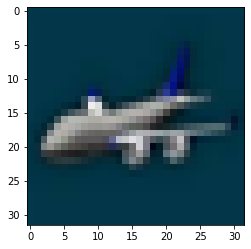

In [104]:
plt.imshow(image_load(test_image, image_size))

**show result image**

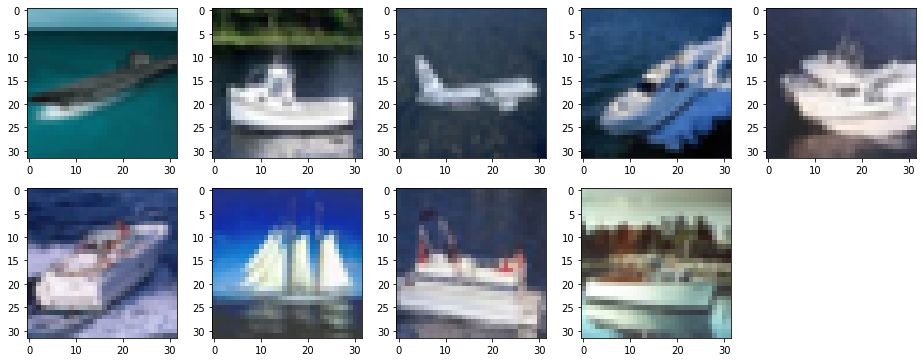

In [115]:
w = 10
h = 10
fig = plt.figure(figsize=(16, 16))
colum = 5
rows = 5

for i in range(1, colum*rows+1):
    try:
        image = image_load(train_image_path[result_id[i]], image_size)
        fig.add_subplot(rows, colum, i)
        plt.imshow(image)
    except:
        pass
plt.show()